# Exercise 4: Ridge Regression on the Franke function with resampling (score 20 points)

Write your own code for the Ridge method, either using matrix inversion or the singular value decomposition as done in the previous exercise. Perform the same bootstrap analysis as in the Exercise 2 (for the same polynomials) and the cross-validation in exercise 3 but now for different values of λ. Compare and analyze your results with those obtained in exercises 1-3. Study the dependence on λ.

Study also the bias-variance trade-off as function of various values of the parameter λ. For the bias-variance trade-off, use the bootstrap resampling method. Comment your results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common import *
from sklearn import linear_model as lm
from sklearn.model_selection import cross_val_score, GridSearchCV
import os
#import seaborn as sns

print(f"Root directory: {os.getcwd()}")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

%matplotlib inline 

Root directory: /home/arefrode/uio/fys-stk4155/projects/FYS-STK4155-Prj1_report/code


## 4.0 Data
Defining and creating the data


In [2]:
#generate some data:
SEED = 4155
np.random.seed(SEED)
n = 20
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
x,y = np.meshgrid(x,y)
t_nonoise = FrankeFunction(x, y)
t = t_nonoise + noise_factor(n, factor=0.2)
degree = 12
min_lambda = -9
max_lambda = 4
nlambdas = 500
lambdas = np.logspace(min_lambda,max_lambda, nlambdas)

# 4.1 initial search landscape

In [3]:
test_mse = np.zeros((degree, nlambdas))
train_mse = np.zeros_like(test_mse)
model_list = np.empty_like(test_mse, dtype=object)
optimal_deg = 0
optimal_lmb = 0
lambda_degree = 0
best_mse = np.inf

for deg in range(1, degree+1):
    for lmb in range(len(lambdas)):

        X = create_X(x,y,n=deg)

        X_train, X_test, z_train, z_test = prepare_data(X, t.ravel(), SEED, scale_X=True, skip_intercept=True)

        model = RidgeRegression(lambdas[lmb])
        z_hat_train = model.fit(X_train, z_train)
        z_hat_test = model.predict(X_test)

        test_mse[deg-1,lmb] = MSE(z_test, z_hat_test)
        train_mse[deg-1, lmb] = MSE(z_train, z_hat_train)
        model_list[deg-1,lmb] = model
        
        if test_mse[deg-1,lmb] < best_mse:
            best_mse = test_mse[deg-1, lmb]
            optimal_deg = deg
            optimal_lmb = lambdas[lmb]
            lambda_degree = lmb

print(best_mse)
print(optimal_lmb)
print(optimal_deg)
print(train_mse[deg-1, lmb])
optimal_model = model_list[deg-1, lambda_degree]

0.14973420584785732
1e-09
6
0.16161175600501493


Surface-plot of optimal lambda

In [7]:
import matplotlib.ticker as mticker
%matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.title.set_text("Plot of the Search Landscape")
ax.set_xlabel("Polynomial degree"); ax.set_ylabel("Lambda index"); ax.set_zlabel("MSE")
#ax.set_yticklabels(f"{np.log10(lambdas[i])}" for i in np.linspace(0,499,6,dtype=int))
ax.set_xticklabels(f"{deg-2}" for deg in range(1, degree+2,2))

degs, lambs = np.meshgrid(range(degree), range(nlambdas))
print(degs.shape)
print(lambs.shape)
print(test_mse.shape)
surf = ax.plot_surface(degs, lambs, test_mse.swapaxes(0,1), cmap=cm.coolwarm)
ax.view_init(elev=14., azim=-58.)
ax.scatter(optimal_deg-1, lambda_degree, best_mse, c='r', marker='o', s=100)
plt.savefig(f"{REPORT_FIGURES}{EX4}search_landscape_ridge.pdf")

Using matplotlib backend: TkAgg
(500, 12)
(500, 12)
(12, 500)


/tmp/ipykernel_487538/3545709525.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(f"{deg-2}" for deg in range(1, degree+2,2))
/tmp/ipykernel_487538/3545709525.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig(f"{REPORT_FIGURES}{EX4}search_landscape_ridge.pdf")


Betaplot showing effect of ridge

KeyboardInterrupt: 

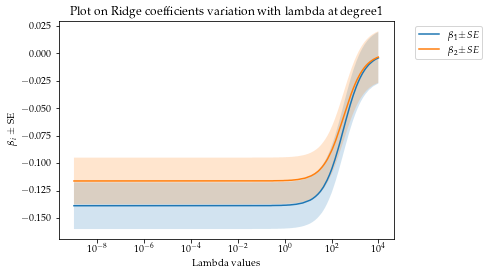

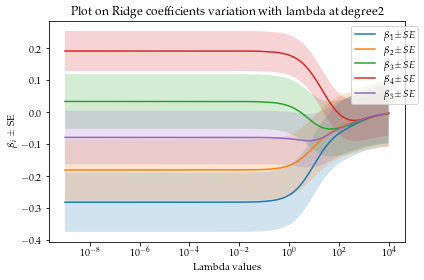

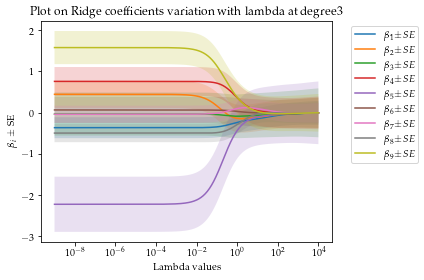

In [5]:
%matplotlib inline
for deg in range(1, degree-3):     # Only want the first 8
    summaries_df = pd.DataFrame()
    for lmb in lambdas:
        X = create_X(x,y,n=deg)
        X_train, X_test, z_train, z_test = prepare_data(X, t.ravel(), 4155, scale_X=True, skip_intercept=True)
        model = RidgeRegression(lmb)
        model.fit(X_train, z_train)
        summary_df = model.summary()
        summaries_df = pd.concat([summaries_df, summary_df], axis=0)

    fig = plot_beta_errors_for_lambdas(summaries_df, deg)
    plt.savefig(f"{REPORT_FIGURES}{EX4}beta_plot_ridge_{deg}.pdf")

Some code that implements the brute force lambda selection, this is inspired by the lecture 30.09

In [ ]:
# NO NOISE

X = create_X(x,y,degree)
X_train, X_test, t_train, t_test = prepare_data(X,t_nonoise.ravel(),SEED, scale_X=True, skip_intercept=True)

print(X_train.shape)

MSERidgePredict = np.zeros(nlambdas)
MSEOurRidge = np.zeros(nlambdas)
lambdas = np.logspace(min_lambda, max_lambda, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]

    # SKlearn
    RegRidge = lm.Ridge(lmb,fit_intercept=False) # ALWAYS keep intercept False
    RegRidge.fit(X_train, t_train)
    tpredictRidge = RegRidge.predict(X_test)
    MSERidgePredict[i] = MSE(t_test, tpredictRidge)

    # our Ridge
    model = RidgeRegression(lmb)
    model.fit(X_train, t_train)
    tpredictOur = model.predict(X_test)
    MSEOurRidge[i] = MSE(t_test, tpredictOur)

plt.figure()
plt.plot(np.log10(lambdas), MSEOurRidge, 'm', label = "MSE Our Ridge Test")
plt.plot(np.log10(lambdas), MSERidgePredict, 'y--', label = 'MSE SL Ridge Test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
# NOISE and OLS for comparison

X = create_X(x,y,degree)
X_train, X_test, t_train, t_test = prepare_data(X,t.ravel(), SEED, scale_X=True, skip_intercept=True)

#X_train = X_train[:,1:]
#X_test = X_test[:,1:]

nlambdas = 500
MSERidgePredict = np.zeros(nlambdas)
MSEOurRidge = np.zeros(nlambdas)
MSEols = np.zeros(nlambdas)
lambdas = np.logspace(min_lambda, max_lambda, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]

    # SKlearn
    RegRidge = lm.Ridge(lmb,fit_intercept=False) # ALWAYS keep intercept False
    RegRidge.fit(X_train, t_train)
    tpredictRidge = RegRidge.predict(X_test)
    MSERidgePredict[i] = MSE(t_test, tpredictRidge)

    # our Ridge
    model = RidgeRegression(lmb)
    model.fit(X_train, t_train)
    tpredictOur = model.predict(X_test)
    MSEOurRidge[i] = MSE(t_test, tpredictOur)

    # OLS :)
    """
    ols = OLS()
    ols.fit(X_train, t_train)
    olspredict = ols.predict(X_test)
    MSEols[i] = MSE(t_test, olspredict)
    """

plt.figure()
plt.plot(np.log10(lambdas), MSEOurRidge, 'm', label = "MSE Our Ridge Test")
plt.plot(np.log10(lambdas), MSERidgePredict, 'y--', label = 'MSE SL Ridge Test')
#plt.plot(np.log10(lambdas), MSEols, 'b--', label = "MSE Our OLS Test")
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Bootstrapping
looping through a fewer set of lambda values, still from -9 to 4

In [ ]:
np.random.seed(SEED)
maxdegree = 18
n_points = [20, 40]
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
x,y = np.meshgrid(x,y)
z = FrankeFunction(x,y) + noise_factor(n, factor=0.2)

min_lambda = -9
max_lambda = 4
nlambdas = 13
lambdas = np.logspace(min_lambda,max_lambda, nlambdas+1)

In [ ]:
for n in n_points:
    for i in [0, len(lambdas)-1]:
        n_bootstraps = int(0.2*n**2)
        lmb = lambdas[i]
        polydegree = np.arange(1, maxdegree+1)
        MSE_test, MSE_train, bias, variance = bootstrap(x, y, z, maxdegree, n_bootstraps, RidgeRegression(lmb), SEED)

        plt.plot(polydegree, MSE_test,"m", label='MSE test')
        #plt.plot(polydegree, MSE_train,"c", label='MSE train')
        plt.plot(polydegree, bias,"b--", label='bias')
        plt.plot(polydegree, variance,"r--", label='Variance')
        #plt.plot(polydegree, bias+variance,"g--", label='bias+variance')

        plt.title(fr"Bias-Variance tradeoff for {n*n} datapoints using {n_bootstraps} bootstraps with $\lambda$: {lmb:.0e}")
        plt.xlabel("Model complexity / Polynomial Degree")
        plt.ylabel("Prediction Error - MSE")
        plt.xticks(polydegree)
        plt.grid(True)
        plt.legend()
        plt.savefig(f"{REPORT_FIGURES}{EX4}ridge_complexity_using_bootstrap_function_lmb{n}{i}.pdf")
        plt.show()

# Cross-validation using Ridge

In [ ]:
np.random.seed(SEED)
maxdegree = 12
n = 20
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
x,y = np.meshgrid(x,y)
z = FrankeFunction(x,y) + noise_factor(n, factor=0.2)

min_lambda = -9
max_lambda = 4
nlambdas = 3
lambdas = np.logspace(min_lambda,max_lambda, nlambdas+1)

for i in range(nlambdas+1):
    lmb = lambdas[i]

    boot_strp_MSE_test, _, _, boot_strp_variance = bootstrap(x, y, z, maxdegree, int(0.2*n**2), RidgeRegression(lmb), SEED)
    boot_strp_std = np.sqrt(boot_strp_variance)

    for degree in range(3,maxdegree):
        X = create_X(x,y,degree)
        X = remove_intercept(X)

        mean_folds_error = np.zeros(6)
        mse_std_arr = np.zeros(6)
        for folds in range(5,11):
        
            implemented_scores = cross_val(k = folds, model = "Ridge", X = X, z = t, degree=degree, shuffle=True, scale_t=False, lmb=lmb)
            mean_folds_error[folds-5] = np.mean(implemented_scores)
            mse_std_arr[folds-5] = np.std(implemented_scores)
    
        plt.plot(np.arange(5,11), np.ones(6)*boot_strp_MSE_test[degree],"--", label ="Mean MSE bootstrap with STD")
        #plt.fill_between(np.arange(5,11), np.ones(6)*boot_strp_MSE_test[degree]-boot_strp_std[degree],
                        #np.ones(6)*boot_strp_MSE_test[degree]+boot_strp_std[degree], alpha = 0.2 )
        plt.plot(np.arange(5,11), mean_folds_error, "o--",  label = "Mean MSE CV")
        plt.fill_between(np.arange(5,11), mean_folds_error-mse_std_arr, mean_folds_error+mse_std_arr,  alpha = 0.2, color = "darkorange")
        plt.title(fr"Model complexity: {degree} degrees, $\lambda$ = {lmb:.2e}")
        plt.xlabel("K-fold")
        plt.ylabel("MSE")
        #plt.ylim(0,2)
        plt.xticks(np.arange(5,11))
        plt.grid(True)
        plt.legend()
        plt.savefig(f"{REPORT_FIGURES}{EX4}mse_cv_boot{i}{degree}.pdf")

        plt.show()